Dans ce script, nous allons tester différents modèles de type convolution Nelle pour examiner leur performance. Nous allons ensuite tester s'ils sont robustes lorsqu'on applique une rotation à l'image d'entrée.

# testing each network for different rotations

In [1]:
import retinoto_py as fovea
args = fovea.Params(do_mask=True)
args

Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	 user laurentperrinet	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 2018 has been set.


Params(image_size=224, do_mask=True, do_fovea=False, rs_min=0.0, rs_max=-5.0, padding_mode='zeros', seed=2018, batch_size=80, num_workers=4, in_memory=True, model_name='resnet101', do_scratch=False, num_epochs=20, n_train_stop=40960, n_val_stop=5120, do_full_training=False, lr=0.004, delta1=0.1, delta2=0.0, weight_decay=0.05, label_smoothing=0.1, shuffle=True, verbose=True)

In [2]:
all_angles = fovea.np.linspace(0, 180, 25)
all_angles

array([  0. ,   7.5,  15. ,  22.5,  30. ,  37.5,  45. ,  52.5,  60. ,
        67.5,  75. ,  82.5,  90. ,  97.5, 105. , 112.5, 120. , 127.5,
       135. , 142.5, 150. , 157.5, 165. , 172.5, 180. ])

In [3]:
delta_angle = all_angles[1] - all_angles[0]
all_angles_min = all_angles - delta_angle / 2
# all_angles_min, all_angles_min + delta_angle, delta_angle

In [4]:
# %rm cached_data/17_rotation-attack_name=resnet18_dataset=bbox.npz 

In [ ]:
all_model_names = fovea.all_model_names
all_model_names.append('convnext_base')

for dataset in fovea.all_datasets:
    for model_name in all_model_names:
        npz_filename = args.data_cache / f'17_rotation-attack_name={model_name}_dataset={dataset}.npz'
        print(f'Rotation attack for {model_name=} and {dataset=} \t {npz_filename=}')

        # %rm {npz_filename}  # FORCING RECOMPUTE

        if npz_filename.exists():
            with fovea.np.load(npz_filename) as data:
                attack_angle = data['attack_angle']
                attack_success = data['attack_success']
                all_results = data['results']
        else:
            VAL_DATA_DIR = args.DATAROOT / f'Imagenet_{dataset}' / 'val'
            args = fovea.Params(shuffle=False, do_mask=True, model_name=model_name, n_val_stop=0, batch_size=500, in_memory=False)
            model = fovea.load_model(args)
            model.eval()

            val_dataset = fovea.get_dataset(args, VAL_DATA_DIR, n_stop=0)
            val_loader = fovea.get_loader(args, val_dataset)
            n_val_stop = args.n_val_stop
            if n_val_stop==0: n_val_stop = len(val_loader.dataset)

            # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html 
            criterion = fovea.torch.nn.CrossEntropyLoss(reduction='none')
            # dataset_len = len(val_loader.dataset)
            all_results = fovea.np.empty((len(all_angles), n_val_stop)) 
            all_logits = fovea.np.empty((len(all_angles), n_val_stop, model.fc.out_features)) 
            all_losses = fovea.np.empty((len(all_angles), n_val_stop)) 
            all_labels = []
            outer_progress = fovea.tqdm(
                                    enumerate(zip(all_angles_min, all_angles_min + delta_angle)),
                                    total=len(all_angles_min),
                                    desc="Validating Angles", 
                                    leave=False
                                )
            for i_angle, (angle_min, angle_max) in outer_progress:
                val_dataset = fovea.get_dataset(args, VAL_DATA_DIR, 
                                                angle_min=angle_min, angle_max=angle_max, n_stop=0)
                val_loader = fovea.get_loader(args, val_dataset)

                # correct_predictions = 0
                # total_predictions = 0

                image_count = 0
                for images, true_labels in fovea.tqdm(val_loader, desc=f"Angle [{.5*(angle_min+angle_max):.1f}°]", position=1, leave=False):
                    images = images.to(args.device)
                    true_labels = true_labels.to(args.device)

                    # Get predictions (no need for gradients)
                    with fovea.torch.no_grad():
                        if i_angle==0: all_labels.extend([l.item() for l in true_labels])
                        outputs = model(images)
                        all_logits[i_angle, image_count:(image_count + images.size(0)), :] = outputs.cpu().numpy()
                        
                        _, predicted_labels = fovea.torch.max(outputs, dim=1)
                        correct_predictions_in_batch = (predicted_labels == true_labels)

                        all_results[i_angle, image_count:image_count + images.size(0)] = correct_predictions_in_batch.cpu().numpy()
                        loss = criterion(outputs, true_labels)
                        all_losses[i_angle, image_count:(image_count + images.size(0))] = loss.cpu().numpy()
                    image_count += images.size(0)
                outer_progress.set_postfix(last_acc=f"{all_results[i_angle, :].mean():.4f}")

            attack_angle = all_losses[:, :len(all_labels)].argmax(axis=0)
            attack_idx = all_logits[attack_angle[:len(all_labels)], fovea.np.arange(len(all_labels)), :].argmax(axis=1)
            attack_success = (attack_idx == all_labels)

            fovea.np.savez(npz_filename, 
                    attack_angle=attack_angle,
                    attack_success=attack_success,
                    results=all_results)



Rotation attack for model_name='resnet18' and dataset='full' 	 npz_filename=PosixPath('cached_data/17_rotation-attack_name=resnet18_dataset=full.npz')
Rotation attack for model_name='resnet50' and dataset='full' 	 npz_filename=PosixPath('cached_data/17_rotation-attack_name=resnet50_dataset=full.npz')
Rotation attack for model_name='resnet101' and dataset='full' 	 npz_filename=PosixPath('cached_data/17_rotation-attack_name=resnet101_dataset=full.npz')
Rotation attack for model_name='resnet18' and dataset='bbox' 	 npz_filename=PosixPath('cached_data/17_rotation-attack_name=resnet18_dataset=bbox.npz')
Rotation attack for model_name='resnet50' and dataset='bbox' 	 npz_filename=PosixPath('cached_data/17_rotation-attack_name=resnet50_dataset=bbox.npz')


Validating Angles:   0%|          | 0/25 [00:00<?, ?it/s]

Angle [0.0°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [7.5°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [15.0°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [22.5°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [30.0°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [37.5°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [45.0°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [52.5°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [60.0°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [67.5°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [75.0°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [82.5°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [90.0°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [97.5°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [105.0°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [112.5°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [120.0°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [127.5°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [135.0°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [142.5°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [150.0°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [157.5°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [165.0°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [172.5°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [180.0°]:   0%|          | 0/160 [00:00<?, ?it/s]

Rotation attack for model_name='resnet101' and dataset='bbox' 	 npz_filename=PosixPath('cached_data/17_rotation-attack_name=resnet101_dataset=bbox.npz')


Validating Angles:   0%|          | 0/25 [00:00<?, ?it/s]

Angle [0.0°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [7.5°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [15.0°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [22.5°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [30.0°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [37.5°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [45.0°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [52.5°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [60.0°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [67.5°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [75.0°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [82.5°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [90.0°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [97.5°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [105.0°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [112.5°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [120.0°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [127.5°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [135.0°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [142.5°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [150.0°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [157.5°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [165.0°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [172.5°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [180.0°]:   0%|          | 0/160 [00:00<?, ?it/s]

# analysis: average accuracy for different rotations

In [6]:
all_results.shape

(25, 80477)

In [7]:
all_results.mean(axis=1)

array([0.74333039, 0.73842216, 0.73452042, 0.73004709, 0.72536253,
       0.72190812, 0.71777029, 0.71482535, 0.71058812, 0.70605266,
       0.70331896, 0.70136809, 0.69783913, 0.6953788 , 0.69316699,
       0.69050785, 0.68822148, 0.68436945, 0.67799496, 0.66719684,
       0.65598867, 0.64970116, 0.64642072, 0.64287933, 0.64294146])

/Users/laurentperrinet/app54-nextcloud/science/retinoto_py/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/laurentperrinet/app54-nextcloud/science/retinoto_py/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


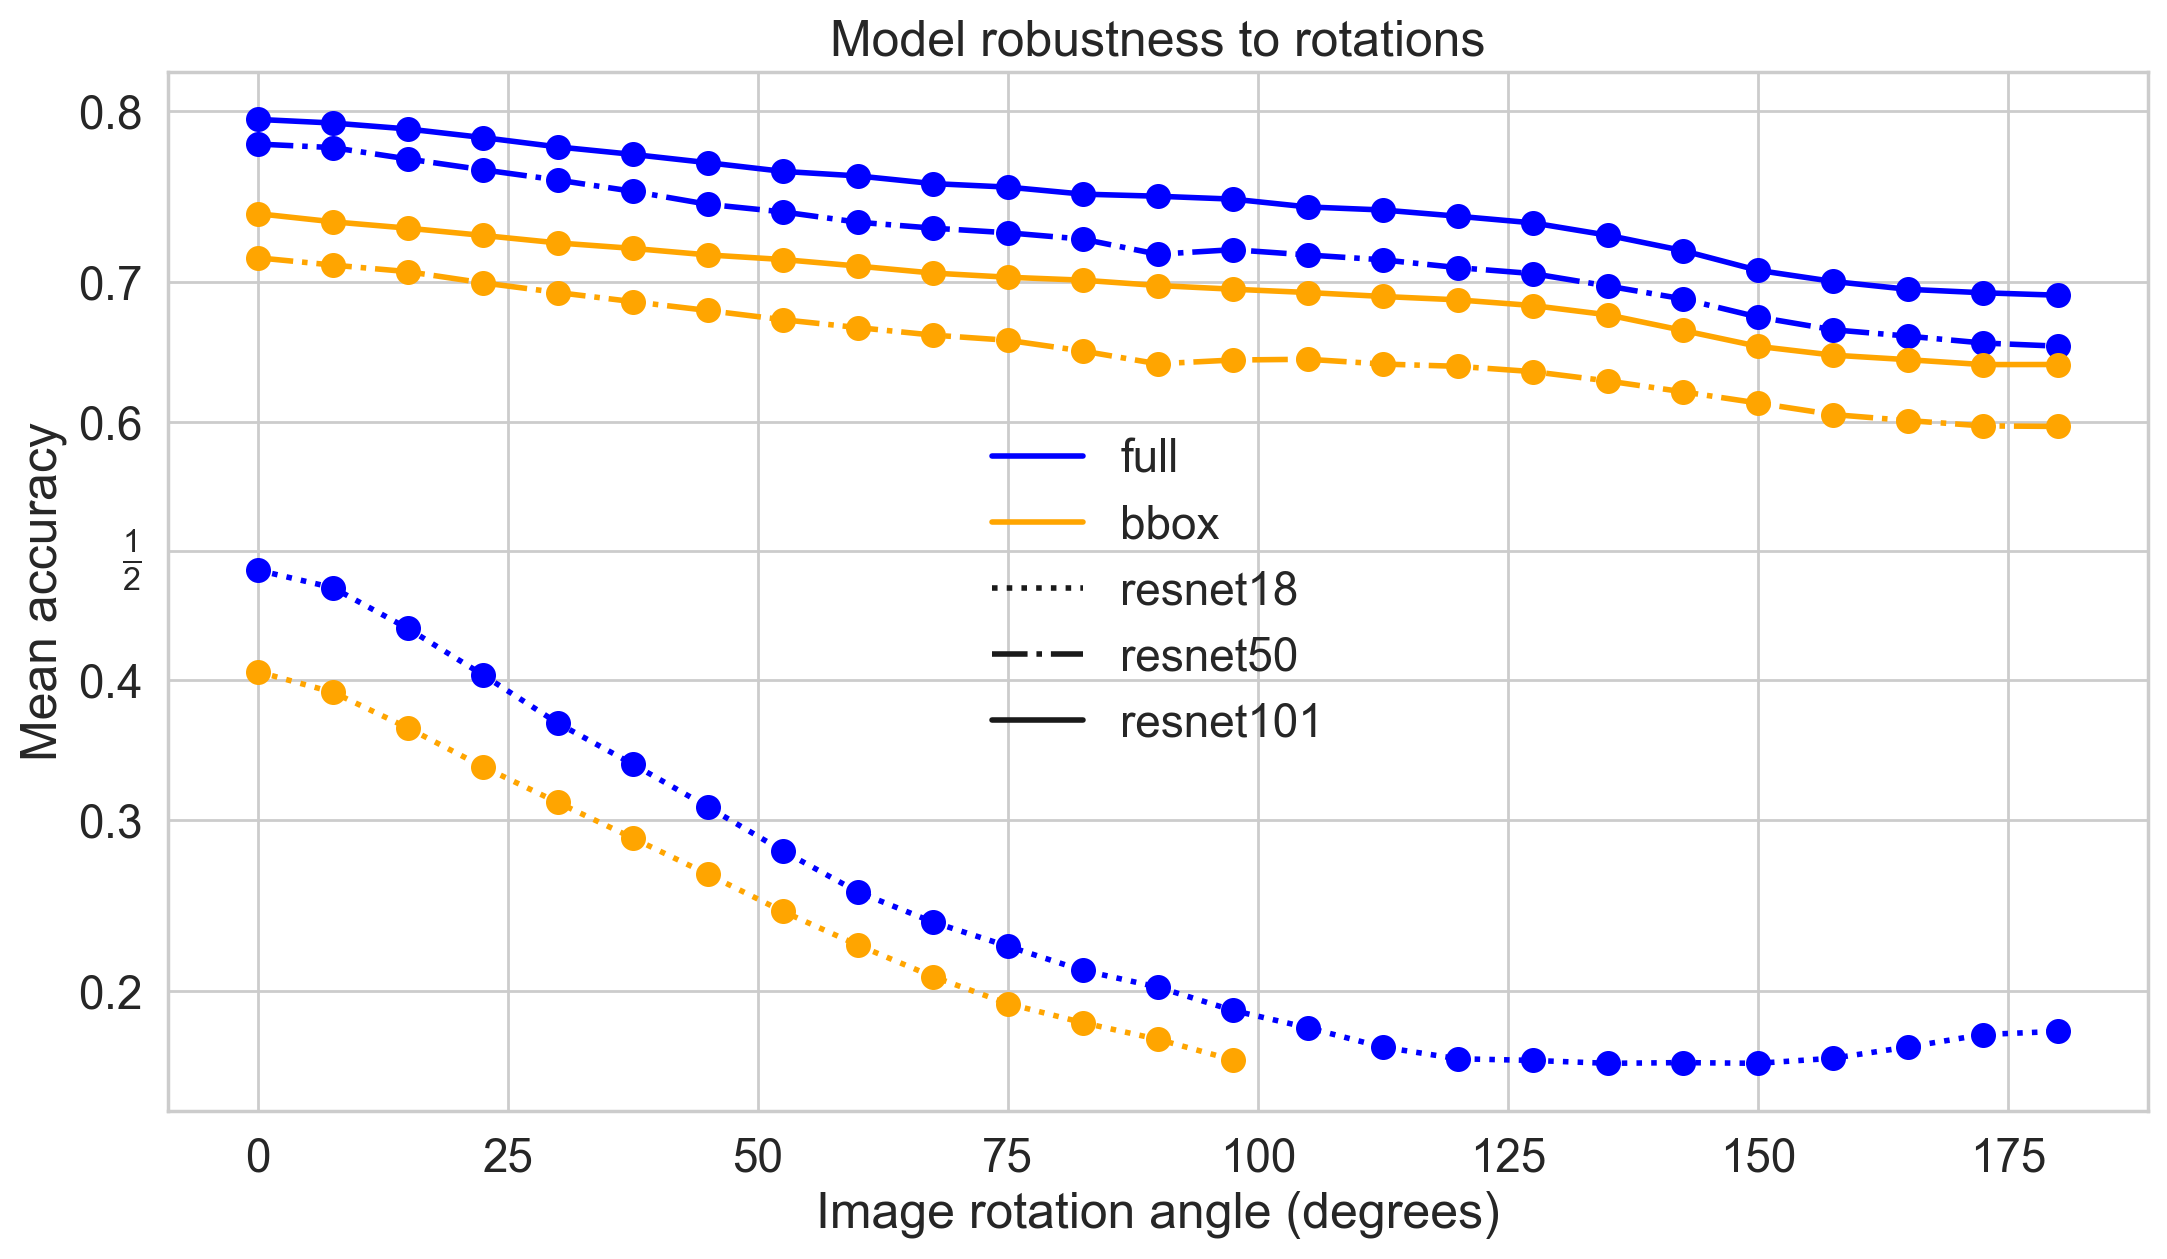

In [ ]:
# --- Create the Plot ---
fig, ax = fovea.plt.subplots()

for dataset, color in zip(fovea.all_datasets, fovea.all_datasets_color):
    for model_name, ls in zip(all_model_names, all_model_names_ls):
        npz_filename = args.data_cache / f'17_rotation-attack_name={model_name}_dataset={dataset}.npz'
        with fovea.np.load(npz_filename) as data:
            all_results = data['results']
        # `all_results` is a boolean array (True/False for correct/incorrect)
        # To compute accuracy, average over the image axis (axis=1)
        mean_accuracy_per_angle = all_results.mean(axis=1)

        # Plot mean accuracy vs. reference angle
        ax.plot(all_angles, mean_accuracy_per_angle, marker='o', linestyle=ls, color=color, lw=2, markersize=8)

# --- Finalize the Plot ---
ax.set_xlabel("Image rotation angle (degrees)")
ax.set_ylabel("Mean accuracy")
ax.set_title("Model robustness to rotations")
# ax.set_ylim(0, 1.05)  # Ensure y axis spans 0 to 1
ax.set_yscale('logit')  # Ensure y axis spans 0 to 1

# Build legends
for dataset, color in zip(fovea.all_datasets, fovea.all_datasets_color):
    ax.plot([], [], linestyle='-', color=color, lw=2, label=dataset)
for model_name, ls in zip(all_model_names, all_model_names_ls):
    ax.plot([], [], linestyle=ls, color='k', lw=2, markersize=8, label=model_name)
ax.legend(frameon=False)


In [9]:
all_angles

array([  0. ,   7.5,  15. ,  22.5,  30. ,  37.5,  45. ,  52.5,  60. ,
        67.5,  75. ,  82.5,  90. ,  97.5, 105. , 112.5, 120. , 127.5,
       135. , 142.5, 150. , 157.5, 165. , 172.5, 180. ])

In [10]:
all_angles_wrap = fovea.np.hstack((all_angles, fovea.np.mod(all_angles[1:]+180, 360)))
all_angles_wrap

array([  0. ,   7.5,  15. ,  22.5,  30. ,  37.5,  45. ,  52.5,  60. ,
        67.5,  75. ,  82.5,  90. ,  97.5, 105. , 112.5, 120. , 127.5,
       135. , 142.5, 150. , 157.5, 165. , 172.5, 180. , 187.5, 195. ,
       202.5, 210. , 217.5, 225. , 232.5, 240. , 247.5, 255. , 262.5,
       270. , 277.5, 285. , 292.5, 300. , 307.5, 315. , 322.5, 330. ,
       337.5, 345. , 352.5,   0. ])

In [11]:
all_angles_wrap_sub = fovea.np.hstack((all_angles[::4], fovea.np.mod(all_angles[::4][1:]+180, 360)))
all_angles_wrap_sub

array([  0.,  30.,  60.,  90., 120., 150., 180., 210., 240., 270., 300.,
       330.,   0.])

In [12]:
mean_accuracy_per_angle_wrap = fovea.np.hstack((mean_accuracy_per_angle, mean_accuracy_per_angle[:-1][::-1]))
mean_accuracy_per_angle_wrap

array([0.74333039, 0.73842216, 0.73452042, 0.73004709, 0.72536253,
       0.72190812, 0.71777029, 0.71482535, 0.71058812, 0.70605266,
       0.70331896, 0.70136809, 0.69783913, 0.6953788 , 0.69316699,
       0.69050785, 0.68822148, 0.68436945, 0.67799496, 0.66719684,
       0.65598867, 0.64970116, 0.64642072, 0.64287933, 0.64294146,
       0.64287933, 0.64642072, 0.64970116, 0.65598867, 0.66719684,
       0.67799496, 0.68436945, 0.68822148, 0.69050785, 0.69316699,
       0.6953788 , 0.69783913, 0.70136809, 0.70331896, 0.70605266,
       0.71058812, 0.71482535, 0.71777029, 0.72190812, 0.72536253,
       0.73004709, 0.73452042, 0.73842216, 0.74333039])

/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/ipykernel_45238/1513976117.py:20: RuntimeWarning: invalid value encountered in sqrt
  ax.plot(angles_rad, fovea.np.sqrt(mean_accuracy_per_angle_wrap), marker='o', linestyle=ls, lw=2, markersize=8, color=color)
/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/ipykernel_45238/1513976117.py:21: RuntimeWarning: invalid value encountered in sqrt
  ax.fill(angles_rad, fovea.np.sqrt(mean_accuracy_per_angle_wrap), alpha=0.05, color=color)


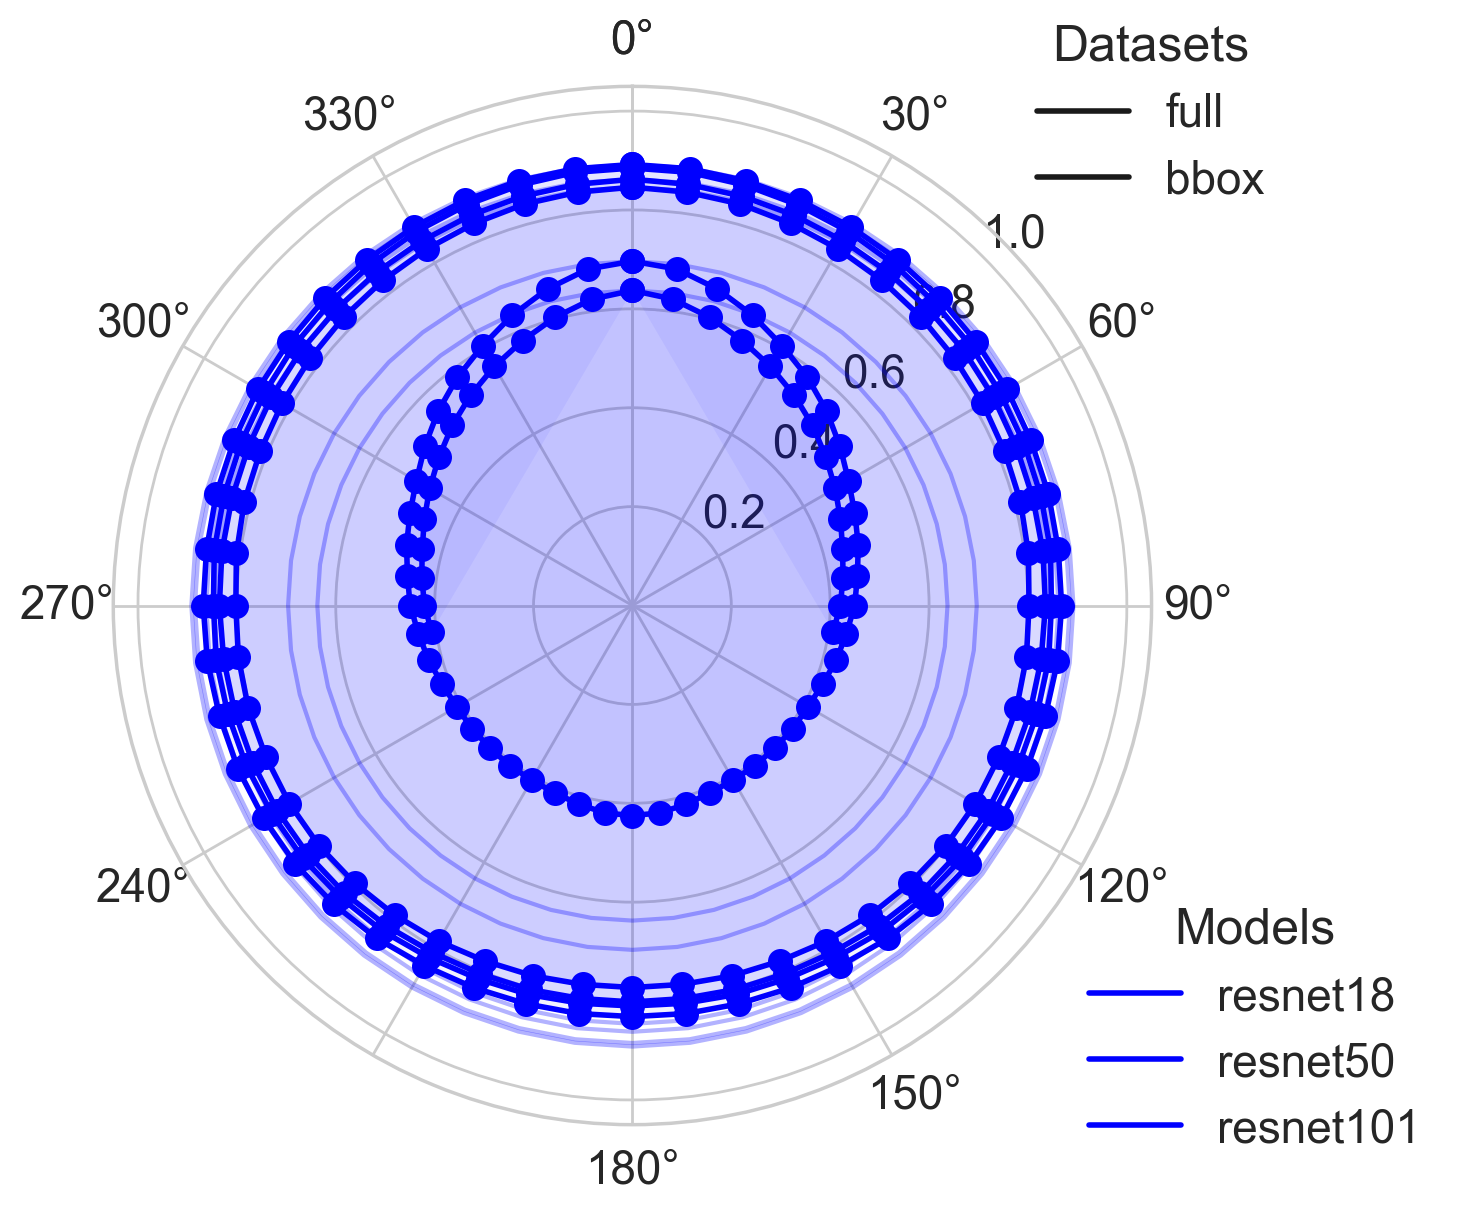

In [ ]:
# --- Création du Polar Plot ---

def figure_rotation_attack_polar(all_datasets, all_datasets_color, all_datasets_ls, 
                                 all_model_names, all_model_color, all_model_names_ls):
    # 1. Créer la figure et l'axe en projection polaire, all_model_names, all_model_names_ls
    fig = fovea.plt.figure()
    ax = fig.add_subplot(111, polar=True)

    # 2. Convertir les angles de degrés en radians (nécessaire pour Matplotlib)
    angles_rad = fovea.np.deg2rad(all_angles_wrap)

    for dataset, ls in zip(all_datasets, all_datasets_ls):
        for model_name, color in zip(all_model_names, all_model_color):
            npz_filename = args.data_cache / f'17_rotation-attack_name={model_name}_dataset={dataset}.npz'
            with fovea.np.load(npz_filename) as data:
                all_results = data['results']

            mean_accuracy_per_angle = all_results.mean(axis=1)
            mean_accuracy_per_angle_wrap = fovea.np.hstack((mean_accuracy_per_angle, mean_accuracy_per_angle[:-1][::-1]))
            ax.plot(angles_rad, fovea.np.sqrt(mean_accuracy_per_angle_wrap), marker='o', linestyle=ls, lw=2, markersize=8, color=color)
            ax.fill(angles_rad, fovea.np.sqrt(mean_accuracy_per_angle_wrap), alpha=0.05, color=color)
            # Ajouter la ligne de performance de base (angle=0)
            # Il faut trouver l'index de l'angle le plus proche de 0
            # zero_angle_idx = (fovea.np.abs(all_angles)).argmin()
            base_accuracy = mean_accuracy_per_angle_wrap[0] #zero_angle_idx]
            # ax.plot(angles_rad[zero_angle_idx], base_accuracy, 'rD', markersize=12, label=f'Performance de base: {base_accuracy:.2f}')
            ax.plot(angles_rad, fovea.np.sqrt(base_accuracy)*fovea.np.ones_like(mean_accuracy_per_angle_wrap), linestyle=ls, lw=1.5, alpha=.3, color=color)

    dataset_handles = []      # will store the handles for the dataset legend
    for dataset, ls in zip(all_datasets, all_datasets_ls):
        # Plot an *empty* line – it will never be shown on the figure,
        # but it gives us a handle with the right colour.
        h, = ax.plot([], [], linestyle=ls, color='k',
                    lw=2, label=dataset)
        dataset_handles.append(h)

    model_handles = []        # will store the handles for the model legend
    for model_name, color in zip(all_model_names, all_model_color):
        # Same idea, but now we vary the line style and keep the colour black.
        h, = ax.plot([], [], linestyle='-', color=color,
                    lw=2, markersize=8, label=model_name)
        model_handles.append(h)

    if len(all_datasets) > 1:
        # First legend – the *datasets* (coloured solid lines)
        leg_datasets = ax.legend(handles=dataset_handles,
                                labels=all_datasets,
                                title='Datasets',
                                loc='upper left',
                                bbox_to_anchor=(.85, 1.1),   # just outside the axes
                                frameon=False)

    if len(all_model_names) > 1:
        # Second legend – the *models* (different line‑styles)
        leg_models = ax.legend(handles=model_handles,
                            labels=all_model_names,
                            title='Models',
                            loc='upper left',
                            bbox_to_anchor=(.9, 0.25),  # lower than the first box
                            frameon=False)

    # IMPORTANT: add the first legend back to the Axes,
    # otherwise it would be overwritten by the second call.
    if len(all_datasets) > 1:
        ax.add_artist(leg_datasets)

    # ax.legend(loc='lower left', bbox_to_anchor=(1.05, 1.1))

    # --- Finalisation du Graphique Polaire ---
    # Définir la direction du zéro (haut) et le sens horaire/anti-horaire
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1) # -1 pour horaire, 1 pour anti-horaire

    # Définir les étiquettes des angles sur le cercle
    # S'assurer que les étiquettes sont alignées
    ax.set_thetagrids(fovea.np.degrees(angles_rad), labels=[f'{a:.0f}°' for a in all_angles_wrap])

    # Définir les limites et les étiquettes de l'axe radial (l'accuracy)
    # ax.set_xlim(0)
    # ax.set_yscale('logit')
    ax.set_ylim(0, 1.05)
    # ax.set_ylim(0)
    # ax.set_ylabel("Accuracy moyenne", labelpad=30) # labelpad pour éloigner l'étiquette du graphique
    ax.set_rlabel_position(45) # Positionner l'étiquette de l'axe radial

    ax.set_xticks(fovea.np.deg2rad(all_angles_wrap_sub))
    # ax.set_yticks([])

    # Ajouter un titre
    # ax.set_title(f"Robustesse du modèle ({args.model_name}) aux rotations\n(Accuracy vs. Angle)", pad=20)
    return fig, ax

fig, ax = figure_rotation_attack_polar(fovea.all_datasets, fovea.all_datasets_color, fovea.all_datasets_ls, all_model_names, all_model_names_color, all_model_names_ls)

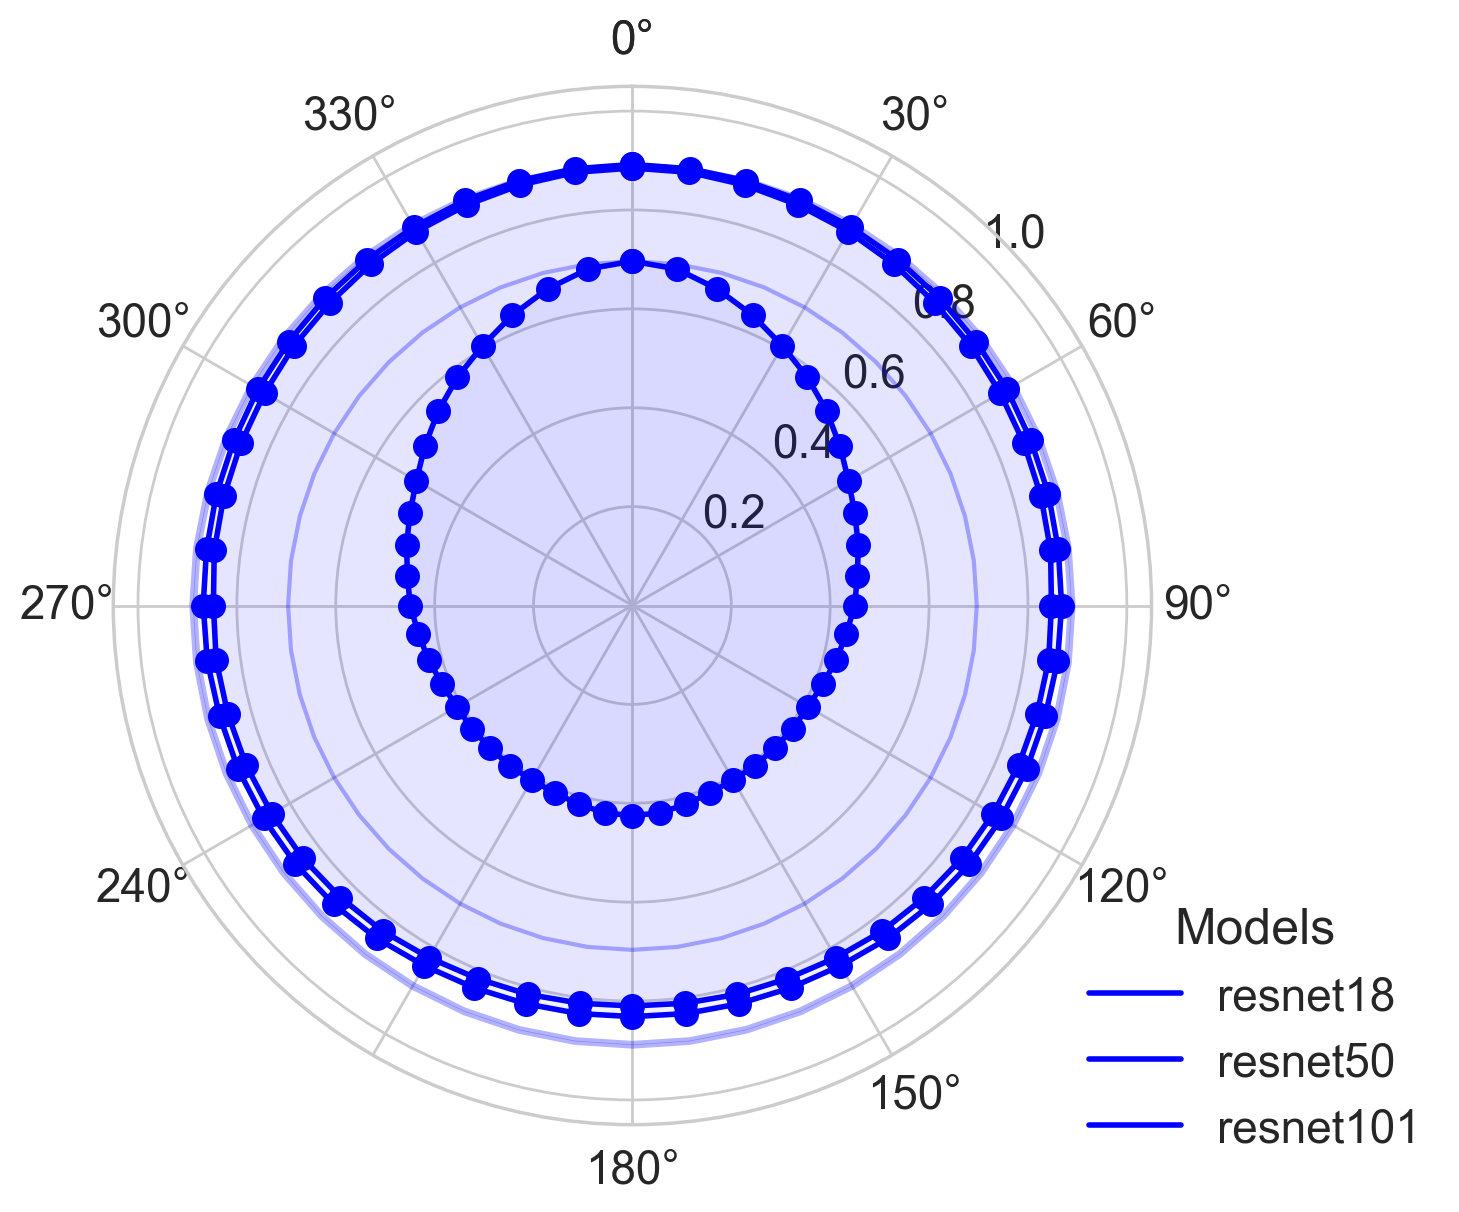

In [ ]:
fig, ax = figure_rotation_attack_polar(fovea.all_datasets[:1], fovea.all_datasets_color[:1], fovea.all_datasets_ls, all_model_names, all_model_names_color, all_model_names_ls)

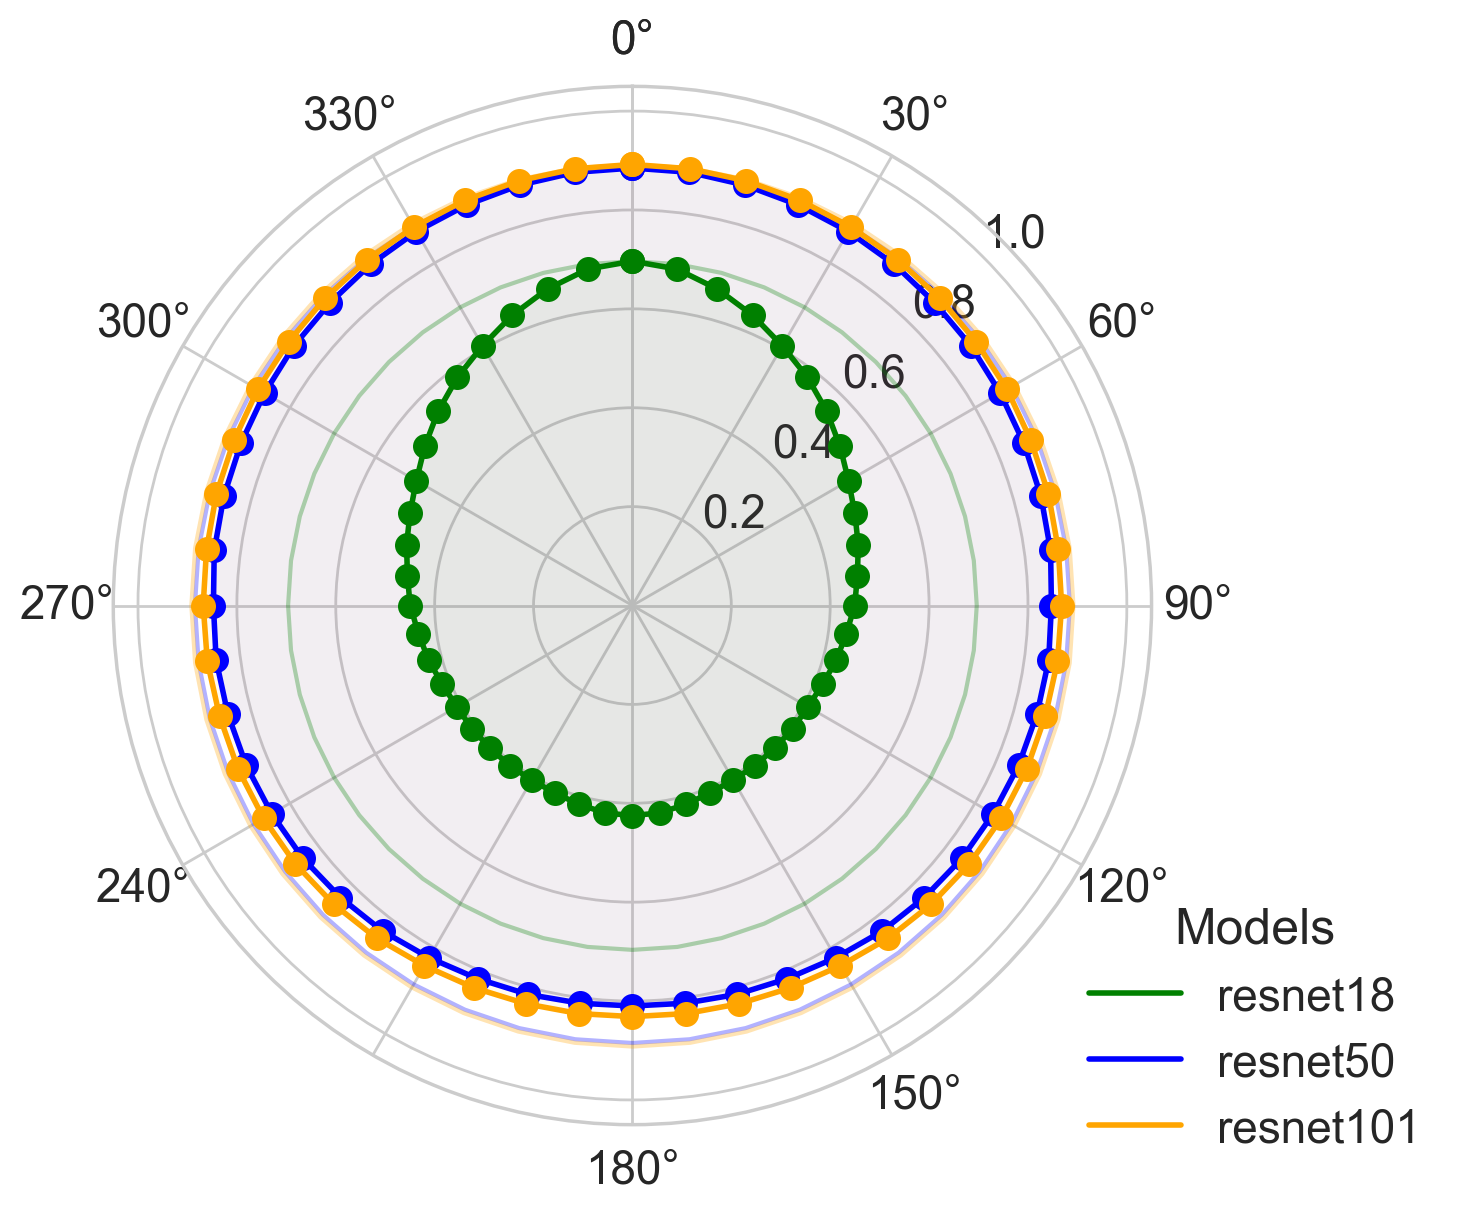

In [ ]:
fig, ax = figure_rotation_attack_polar(fovea.all_datasets[:1], fovea.all_datasets_color[:1], fovea.all_datasets_ls, all_model_names, ['green', 'blue', 'orange'], ['-', '-', '-'])
fovea.savefig(fig, name='17_attack', figures_folder=args.figures_folder, exts=['svg'])

# analysis: per image rotation attack

In [16]:
attack_angle.shape, attack_success.shape

((80000,), (80000,))

In [17]:
fovea.np.unique(attack_angle)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])

In [18]:
all_angles

array([  0. ,   7.5,  15. ,  22.5,  30. ,  37.5,  45. ,  52.5,  60. ,
        67.5,  75. ,  82.5,  90. ,  97.5, 105. , 112.5, 120. , 127.5,
       135. , 142.5, 150. , 157.5, 165. , 172.5, 180. ])

In [19]:
attack_success

array([False, False,  True, ...,  True,  True,  True], shape=(80000,))

In [20]:
attack_success.mean()

np.float64(0.530175)

In [ ]:
all_model_names

['resnet18', 'resnet50', 'resnet101']

In [22]:
fovea.all_datasets

['full', 'bbox']

In [ ]:
for dataset in fovea.all_datasets:
    for model_name in all_model_names:
        npz_filename = args.data_cache / f'17_rotation-attack_name={model_name}_dataset={dataset}.npz'
        with fovea.np.load(npz_filename) as data:
            attack_success = data['attack_success']
            print(npz_filename, attack_success.mean())

cached_data/17_rotation-attack_name=resnet18_dataset=full.npz 0.06758
cached_data/17_rotation-attack_name=resnet50_dataset=full.npz 0.53046
cached_data/17_rotation-attack_name=resnet101_dataset=full.npz 0.57726
cached_data/17_rotation-attack_name=resnet18_dataset=bbox.npz 0.062
cached_data/17_rotation-attack_name=resnet50_dataset=bbox.npz 0.476225
cached_data/17_rotation-attack_name=resnet101_dataset=bbox.npz 0.530175


In [24]:
attack_angle


array([ 0,  8, 12, ..., 24, 15, 22], shape=(80000,))